<a href="https://colab.research.google.com/github/julschwarz/parking_space_detection/blob/main/parking_space_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPARK Task: Detecting Parking Areas in Braunschweig

The file “vehicles.csv“ contains of the centre points of the bounding boxes of all vehicles on the image I showed you (format: latitude, longitude). Beware: the file contains a small percentage of false detections.
The  task is to
identify on-street parking areas in the form of lines parallel to the street like on the example image („example.png“)

*   save your results in some standard format (e.g. JSON of Linestrings)
*   Bonus: visualize your results in some way
Some tips:
*   It may be useful to remove unnecessary vehicles (like off-street vehicles) based on their position beforehand. Roughly 60% of all the points should be on-street. OSM may be useful for that.
*   Think of the problem as a special type of clustering problem, where clusters should form lines based on a certain ruleset rather than form point clouds (like in DBScan or k-means)
*   Avoid the errors shown in the image („errors.png“): Too short lines (good is to have at least 3 vehicles in order to have a valid parking area), lines crossing the street or double assignments of vehicles to multiple parking areas
*   The „vehicle_map.html“ is the map I showed you in our meeting. Open it in any browser to have a quick look at the data, it visualizes a small fraction of the entire dataset on an interactive map. Blue vehicles are on-street, orange ones are off-street.
You can use any software and libraries you find useful.

## 1 )  Import packages

OSMNX hat verschiedene Package Überschneidungen, deswegen der ganze Kram damit es am Ende funktioniert:

In [ ]:
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
  
import os
os.chdir('spatialindex-src-1.8.5')

!./configure
!make

!make install

!pip install rtree

!ldconfig

from rtree import index
from rtree.index import Rtree

p = index.Property()
idx = index.Index(properties=p)
idx


!pip install osmnx
import osmnx as ox

import networkx as nx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  556k  100  556k    0     0   449k      0  0:00:01  0:00:01 --:--:--  449k
checking build system type... x86_64-unknown-linux-gnu
checking for g++... g++
checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C++ compiler... yes
checking whether g++ accepts -g... yes
checking how to run the C++ preprocessor... g++ -E
checking for a BSD-compatible install... /usr/bin/install -c
checking whether ln -s works... yes
checking whether make sets $(MAKE)... yes
checking host system type... x86_64-unknown-linux-gnu
checking how to print strings... printf
checking for gcc... gcc
checking whether we are using the GNU C compil

In [ ]:
#import standard packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Install and load geo packages
!pip install geopandas
!pip install utm 
import utm
import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.ops import nearest_points
from shapely.geometry import MultiLineString
from shapely.ops import linemerge
import fiona

# Vizualization of geo data:
import folium
from folium import FeatureGroup, LayerControl, Map, Marker

# Sklearn Label Encoder to Encode cathegorical features:
from sklearn.preprocessing import LabelEncoder

# Math Operators:
import math
from math import pi as PI
from math import sin, cos, sqrt, atan2, radians

# Loading Bar:
from tqdm import tqdm
  
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Set Google Drive Directory:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
project_folder = "/content/gdrive/My Drive/Coding Projekte/AIPARK task: on-street parking detection/"

## 2 ) Load Data

OSMnx is a Python package that lets you download spatial geometries and model, project, visualize, and analyze street networks and other spatial data from OpenStreetMap’s APIs. Users can download and model walkable, drivable, or bikable urban networks with a single line of Python code, and then easily analyze and visualize them.

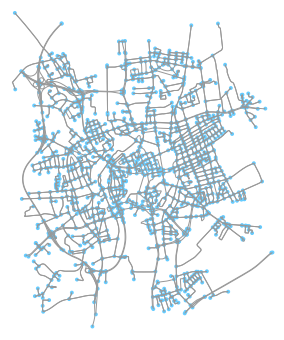

In [ ]:
# Import Straßennetz von Braunschweig (WGS89):
graph = ox.core.graph_from_bbox(52.29, 52.24, 10.56, 10.49, network_type='drive', clean_periphery=True, simplify=True, truncate_by_edge=True)
fig, ax = ox.plot_graph(graph)


In [ ]:
#Import vehicle data:
data = pd.read_csv(project_folder + "vehicles.csv", sep = ";", names=["latitude", "longitude"])

# Create an ID per Vehicle:
data["id"] = np.arange(len(data))

# Create Point Coordinates:
data['coordinates'] = list(zip(data['longitude'], data['latitude']))
data['coordinates'] = data['coordinates'].apply(Point)
data.head()

latitude  longitude  id                                  coordinates
0  52.276103  10.511546   0         POINT (10.5115465 52.27610300000001)
1  52.250378  10.498144   1   POINT (10.4981437534043 52.25037754581707)
2  52.258215  10.517665   2         POINT (10.5176655 52.25821549999999)
3  52.276418  10.498930   3   POINT (10.4989301330366 52.27641819238377)
4  52.252312  10.544720   4  POINT (10.54471989728432 52.25231229515364)

## 3 ) Exploration & Feature Engineering:

Total nodes / crossings: 1624
Total edges / streets: 3601


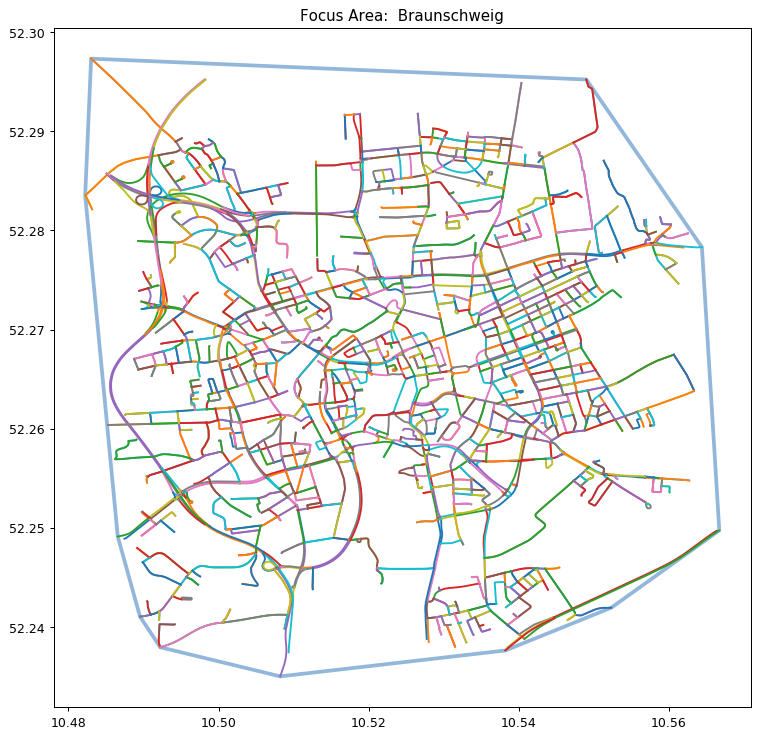

In [ ]:
# Retrieve only edges from the graph (Edges = Streets)
nodes_proj, edges_proj = ox.graph_to_gdfs(graph, nodes=True, edges=True)
print("Total nodes / crossings: " + str(len(nodes_proj)))
print("Total edges / streets: " + str(len(edges_proj)))


# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull

#Get coordinates of the convex hull:
x,y = convex_hull.exterior.xy

# Visualize hull
fig = plt.figure(1, figsize=(10,10), dpi=90)
ax = fig.add_subplot(111)
ax.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

# Visualize cars: (takes a lot of computation time though):
#[ax.scatter(p.x,p.y, s= 0.4, c="red") for p in data['coordinates']]

# Visualize streets:
for s in edges_proj.geometry:
    x = [i[0] for i in s.coords]
    y = [i[1] for i in s.coords]
    plt.plot(x,y)

# show plot:
ax.set_title('Focus Area:  Braunschweig')
plt.show()

In [ ]:
# Convert the df to geodf. The active geometry columns will be the coordinates column with the car points:
data = gpd.GeoDataFrame(data, geometry='coordinates')

### Bottleneck: Find closest street for each vehicle

In [ ]:
# B O T T L E N E C K  - don't execute!
# This part needs a lot of computation time, the larger the network is / the more edges exist (took 45 min to compute focus area).

# Get the closest edge to each vehicle and save it in the DataFrame:
data["closest_edge"] = [ox.get_nearest_edge(graph,(p.y,p.x)) for p in tqdm(data["coordinates"])] 
data["closest_edge"] =  [a[0] for a in data["closest_edge"]]           

100%|██████████| 25187/25187 [58:35<00:00,  7.58it/s]


In [ ]:
# C A C H I N G - don't execute!
# Save the closest edges so we can access them faster later

# Shapefiles have some limitations, including:
# They cannot have multiple columns with geometry data
# The geometries cannot contains multiple types (so eg both Points and LineStrings)

#So lets take only the Edge Data + an ID (so order stays the same):
save= data.set_geometry('closest_edge')
save.geometry.name
save = gpd.GeoDataFrame(save, geometry='closest_edge')
save.drop(['latitude', 'longitude', 'coordinates'], axis =1, inplace = True)

# Write those rows into a new Shapefile
save.to_file(project_folder + "closest_edges_neu.shp")

### Import closest street for each vehicle

In [ ]:
# Import cached "closest_edge"-data:
closest_edges = gpd.GeoDataFrame.from_file(project_folder + "closest_edges_neu.shp")
closest_edges.head()

id                                           geometry
0   0  LINESTRING (10.51074 52.27470, 10.51084 52.274...
1   1  LINESTRING (10.49229 52.25599, 10.49278 52.255...
2   2  LINESTRING (10.51771 52.25812, 10.51766 52.258...
3   3  LINESTRING (10.50150 52.27406, 10.50107 52.274...
4   4  LINESTRING (10.53543 52.24695, 10.53561 52.246...

In [ ]:
# Join as a new column to DataFrame:
data["closest_edge"] = closest_edges.geometry
data.head()

latitude  longitude  ...  dist_to_closest_edge street_label
0  52.276103  10.511546  ...              0.001093          366
1  52.250378  10.498144  ...              0.000012            4
2  52.258215  10.517665  ...              0.000017          516
3  52.276418  10.498930  ...              0.000216           73
4  52.252312  10.544720  ...              0.000595          927

[5 rows x 8 columns]

### Calculate Distance Functions

In [ ]:
# Define some helpful functions:
def distance_cartesian(x1, y1, x2, y2):
    dx = x1 - x2
    dy = y1 - y2
    return sqrt(dx * dx + dy * dy)
  
def dist_in_meter (point1,point2):
  x1, y1, z1, u = utm.from_latlon(point1.y, point1.x)
  x2, y2, z2, u = utm.from_latlon(point2.y, point2.x)
  return distance_cartesian(x1, y1, x2, y2)

# Whyever longitude and latitude are switched, so we have to reswitch them back:
def get_edge_coords(edge):
  coordinates =  list(edge.coords)
  coordinates = [(coordinates[i][1], coordinates[i][0]) for i in range(len(coordinates))]
  return coordinates 

In [ ]:
# Create 2 new features: closest_edge_coords & Dist to closest Edge
print("Computing...")
data["closest_edge_coords"] = [get_edge_coords(edge) for edge in data["closest_edge"]]
print("Closest Edge Coords computed.")
print("Computing...")
data["dist_to_closest_edge"] = [data["coordinates"][i].distance(data["closest_edge"][i]) for i in range(len(data))]
print("Dist to closest Edge computed.")
print("Finished")

Computing...
Closest Edge Coords computed.
Computing...
Dist to closest Edge computed.
Finished


In [ ]:
# Create a Feature with the Street Label (Number Encoded):
  
# instantiate labelencoder object
le = LabelEncoder()
# create new label feature columns
data["street_label"] = le.fit_transform([str(edge.bounds) for edge in data["closest_edge"]])
data["street_label"][:10]

0     365
1       5
2     514
3      72
4     925
5     971
6    1192
7     956
8    1007
9     396
Name: street_label, dtype: int64

### Delete offsite parked cars

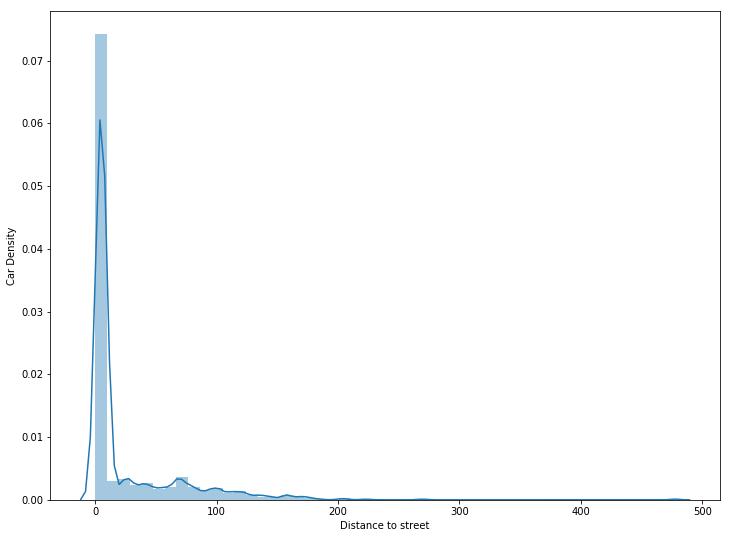

In [ ]:
# How far are cars on avergae located from the street
def plot_car_dist_to_street (data):
  plt.figure(figsize=(12,9))
  ax = sns.distplot(data["dist_to_closest_edge"][:1000] *111212.69702777213 # Factor for approximation in meter
                   )
  ax.set_ylabel("Car Density")
  ax.set_xlabel("Distance to street")

plot_car_dist_to_street (data)

In [ ]:
# Drop Vehicles that are too distant from any streets:

#Make out which ones are parked more than 12m away from any street:
parked_too_far_indx = np.where(data["dist_to_closest_edge"] > 0.00012)[0] 
print(str(len(parked_too_far_indx)) + " cars are parked too far to be considered as on street parking")
print("We removed {0:.2f}% of all the points. The hint was 40%".format(len(parked_too_far_indx)/len(data)*100))

# delete all that have more than 10m distance from a street
data_reduced = data.drop(parked_too_far_indx, axis =0)  
data_reduced.reset_index(inplace=True, drop=True)

12878 cars are parked too far to be considered as on street parking
We removed 51.13% of all the points. The hint was 40%


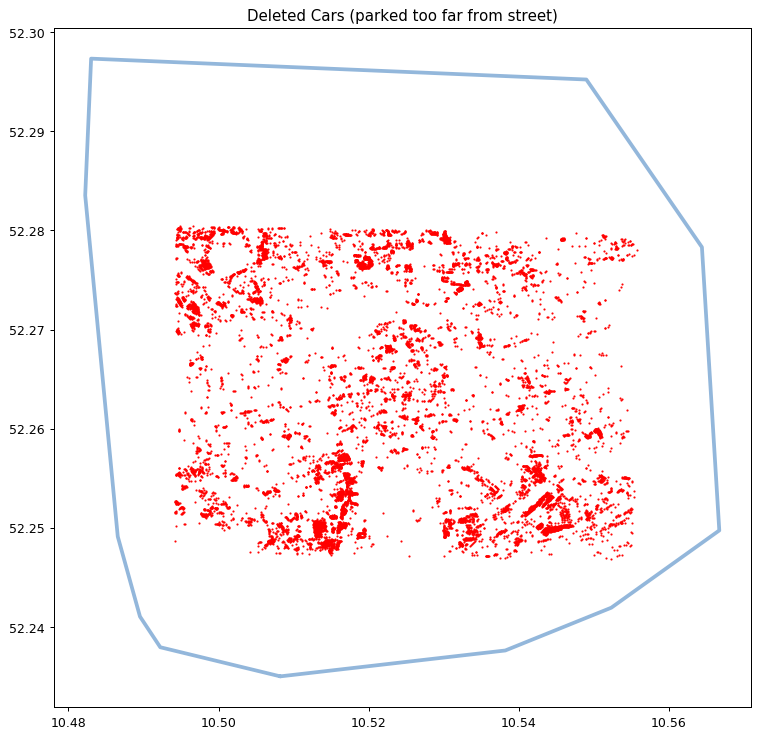

In [ ]:
x,y = convex_hull.exterior.xy

# Visualize hull
fig = plt.figure(1, figsize=(10,10), dpi=90)
ax = fig.add_subplot(111)
ax.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)
fig = plt.figure(1, figsize=(10,10), dpi=90)

#this is to plot each car that was removed (takes a while though):
[ax.scatter(p.x,p.y, s=0.5, c="red") for p in data['coordinates'].iloc[parked_too_far_indx]]

ax.set_title('Deleted Cars (parked too far from street)')
plt.show()

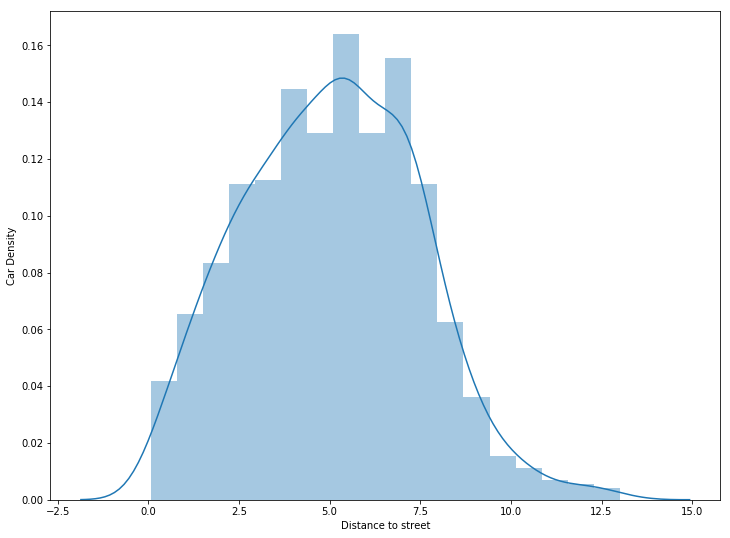

In [ ]:
plot_car_dist_to_street(data_reduced)

### Data Visualization

In [ ]:
def subset_preview(data, parking_coords = None, loc = "test"):
   
  #  We define different locations to check the results. Therefore  we adapt the data to the defined location:
  # (Reason: Folium can't handle more than 3000 Features, so we cant display the whole city at once)
  if loc == "Innenstadt":
    #Innenstadt Preview:
    vehicles_tags_reduced = data.iloc[(np.where((data['latitude'] >= 52.262) & (data['latitude'] <= 52.265) & (data["longitude"] >= 10.52) & (data["longitude"] <= 10.53)))[0]]
  
  if loc == "Residential":
    #Residential Preview:
    vehicles_tags_reduced = data.iloc[(np.where((data['latitude'] >= 52.258) & (data['latitude'] <= 52.263) & (data["longitude"] >= 10.54) & (data["longitude"] <= 10.55)))[0]]
 
  if loc == "Highway":
    #Highway Preview:
    vehicles_tags_reduced = data.iloc[(np.where((data['latitude'] >= 52.25734) & (data['latitude'] <= 52.25968) & (data["longitude"] >= 10.52312) & (data["longitude"] <= 10.53329)))[0]]
  
  if loc == "test":
    #Residential Preview:
    vehicles_tags_reduced = data.iloc[(np.where((data['latitude'] >= 52.26682) & (data['latitude'] <= 52.27149) & (data["longitude"] >= 10.53785) & (data["longitude"] <= 10.54534)))[0]]
  

  # Define the geometry:
  #vehicles_tags_reduced = geopandas.GeoDataFrame(vehicles_tags_reduced, geometry='coordinates')
  
  d = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
       'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
       'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
       'gray', 'black', 'lightgray', 'darkgray','darkpurple', 'white', 'pink', 'lightblue', 'lightgreen']
  
 
  # map subset:
  #vehicles_tags_reduced.reset_index(inplace=True, drop=True)
  
  #initialize map
  folium_map = folium.Map(location=[vehicles_tags_reduced['latitude'].mean(), vehicles_tags_reduced["longitude"].mean()],
                          zoom_start=17,
                          tiles='CartoDB dark_matter'
                         )

  # To represent all streets:
  streets_group = FeatureGroup(name='Streets')
  STREET=folium.PolyLine(locations=vehicles_tags_reduced["closest_edge_coords"],weight=5,opacity=0.4, color = 'green')
  STREET.add_to(streets_group)
  streets_group.add_to(folium_map)
 
  # To represent all parking:
  if parking_coords != None:
    parking_group = FeatureGroup(name='Parking')
    parking1 = folium.PolyLine(locations=parking_coords,weight=7,opacity=1, color = 'red')
    parking1.add_to(parking_group)
    parking_group.add_to(folium_map)
 
  # To represent all cars:
  vehicle_group = FeatureGroup(name='Vehicles')
  for i in vehicles_tags_reduced.index: 
    folium.CircleMarker(
        location=[vehicles_tags_reduced['latitude'][i], vehicles_tags_reduced["longitude"][i]],
        radius= 0.4,
        color= "#007849",
        opacity=4,
        popup=folium.Popup("Street No.: " + str(vehicles_tags_reduced["street_label"][i]) + "Car ID: " + str(vehicles_tags_reduced["id"][i])),
        fill=False
    ).add_to(vehicle_group)
  vehicle_group.add_to(folium_map)

    
  #add layer control:
  LayerControl().add_to(folium_map)
  return folium_map
  

In [ ]:
subset_preview(data_reduced, None , loc = "test")

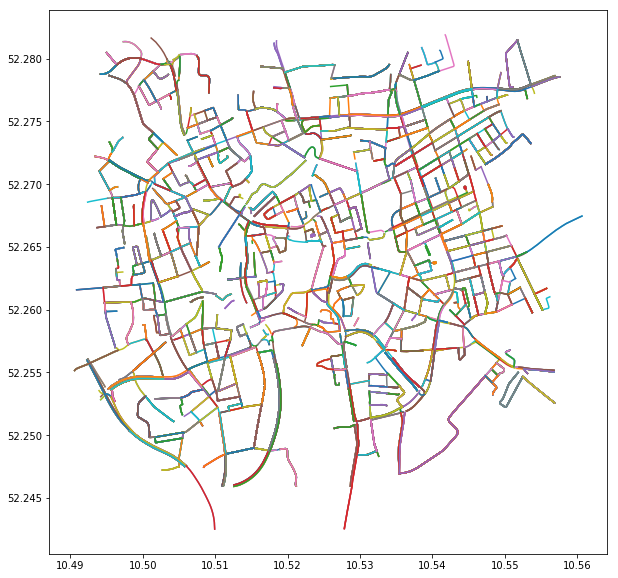

In [ ]:
def plot_lines(lines):
#Visualization
  plt.figure(figsize = (10,10))
  for s in lines:
      x = [i[0] for i in s.coords]
      y = [i[1] for i in s.coords]
      plt.plot(x,y)
  plt.show()
  
plot_lines(data_reduced.closest_edge)

## 4 ) Parking Area Extraction

A set of vehicles is merged into one parking area, if the
following conditions are fulfilled:
*   A parking area is formed by connecting vehicle center points (vertices) through edges
*   A parking area must be formed by at least three vehicle vertices
*   The edge length between two vertices is < 12 meters (twice the avg. parking
spot length)
*   The absolute mean angle between the parking area and the main direction
angle of the corresponding street must not be larger than 6 Degrees

In [ ]:
# Needed Functions:

# Function to get the angle between two Linestrings
def get_angle(l1, l2): 

  l1 = list(l1.coords)
  l2 = list(l2.coords)
  m1 = np.divide((l1[1][1]-l1[0][1]),(l1[1][0]-l1[0][0]))
  m2 = np.divide((l2[1][1]-l2[0][1]),(l2[1][0]-l2[0][0]))

  angle_rad = abs(math.atan(m1) - math.atan(m2))
  angle_deg = angle_rad*180/PI
  return angle_deg


# Function to get the angle of one Linestrings
def get_angle1(l1): 
  
  l1 = list(l1.coords)
  m1 = np.divide((l1[1][1]-l1[0][1]),(l1[1][0]-l1[0][0]))

  angle_rad = abs(math.atan(m1))
  angle_deg = angle_rad*180/PI
  return angle_deg


# Function to check if two points fulfill all criteria to be merged into a parking LineString:
def fullfills_conditions (point, o, street):
  fulfilled = False
  
  #Linestring between two points:
  l = LineString([point, o])
  
  # COND: Both points aren't on opposite sides of the street
  if street.crosses(l) == False:
    
    # COND: distance smaller 12m
    if dist_in_meter(point, o) <= 12:
      
      #find closest street segment to both points:
      vertice1 = nearest_points(point,street) [1]
      vertice2 = nearest_points(o,street) [1]
      street_seg = LineString([vertice1,vertice2])
      # plot_lines([street_seg, l]) #Visualize how Parking and Street are interrelated
          
      # COND: angle street-line < 6 Degrees
      if get_angle(l, street_seg) <= 6:
        fulfilled = True
  return fulfilled

In [ ]:
# Main algo to detect potential parking space :

pot_parking = []
street_label = []


# Group data by Street
grouped = data_reduced.groupby('street_label')

# Loop over all groups:
for street_id, group_df in grouped:
  
  cluster = []
  cluster_points = []
  
  #If there are less than 3 cars in a street, skip it:
  if len(group_df) < 3:
    continue
  
  # Get the street that this cluster is located in:
  group_df.reset_index(inplace = True, drop = True)
  street = group_df["closest_edge"][0]
  
  # Sort Cluster points after location:
  if get_angle1(street) < 45:
    group_df.sort_values(by='latitude' , inplace=True)
  else: group_df.sort_values(by='longitude' , inplace=True)
  
  # Reset group index and get new indexes of that group:
  group_df.reset_index(inplace = True, drop = True)
  indxs = group_df.index
  
  # loop over all members of the group and define current executed point and other_points_df
  for i in range(len(group_df)):
    point = group_df["coordinates"][i]
    
    # define dataframe with all points more north / east
    others_points_df = group_df.drop(np.arange(i+1), axis=0)
    
    # sort them after distance to current point:
    others_points_df["distance"] = [dist_in_meter(point, o) for o in others_points_df["coordinates"]]
    others_points_df.sort_values(by='distance' , inplace=True)
    others_points_df.reset_index(inplace = True, drop = True)
 
    for j in range(len(others_points_df)): 
      if fullfills_conditions (point, others_points_df.coordinates[j], street) == True:
        pot_parking.append(LineString([point, others_points_df.coordinates[j]]))
        street_label.append(street_id)
        break


In [ ]:
#Merging LineStrings that have a touchpoint...
multi_line = MultiLineString(pot_parking)
merged_line = linemerge(multi_line)
print(merged_line)

# ...and deleteing these with only 2 vehicles:
parking = [i for i in merged_line if len(i.coords) > 2 ]

MULTILINESTRING ((10.49421186157518 52.27122575258552, 10.4942681155914 52.27125980376344, 10.49432725455147 52.27129505064548, 10.4943865 52.27132750000001, 10.4944565 52.271363, 10.494514 52.271402, 10.4946205 52.2714575), (10.49444 52.2720405, 10.49432171756455 52.27206074699818, 10.49424362909286 52.27207474610843), (10.49427874045801 52.26657275318065, 10.4943465 52.26657649999999), (10.4942995 52.26178950000001, 10.4943962550505 52.26179202525253), (10.49438934780189 52.27867217807457, 10.4943152455896 52.27867393500465, 10.49446758685446 52.27866674647886), (10.4944045 52.27049499999999, 10.49447231881188 52.27041425280529, 10.494423 52.2704665), (10.49452808443709 52.27866474641279, 10.49446758685446 52.27866674647886), (10.4945995 52.27866349999999, 10.49446758685446 52.27866674647886), (10.49451524578262 52.27873144309203, 10.49462475446374 52.27874752973771, 10.4947055 52.278754, 10.4947735 52.27876600000001, 10.49485775403797 52.27877652715596, 10.494933 52.27879050000002),

## 5 ) Results

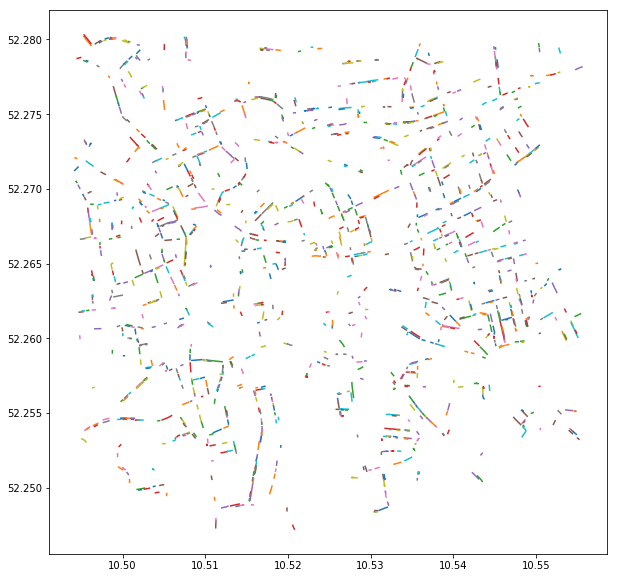

In [ ]:
plot_lines(parking)

In [ ]:
# Switch again long and lat for display in folium:
get_parking_coords = []
  
for i, pa in enumerate(parking):
  temp = []
  for j, po in enumerate(list(pa.coords)):
    temp.append((po[1], po[0]))
  get_parking_coords.append(temp)

In [ ]:
# Vizualize results for the test area:

subset_preview(data, get_parking_coords, loc = "test")

The result is different from the example.png, but mainly because the obervations took place at two different points in time. For example,  Fasanenstraße was a lot more empty at the time of obervation of this dataset, then at the time when the example picture was taken. Anyhow, many of the detected parking areas can also be found in the example.png.

In [ ]:
# Vizualize results for the inner city:

subset_preview(data, get_parking_coords, loc = "Innenstadt")

In the old town of Braunschweig only few parking areas were detected. The reason for this seems to be, that the city network data of Braunschweig did not map most of the small streets there. Vehicles that were located in that area were therefore categorized as too far from any road and removed. This also explains the high percentage of vehicles classified as off road. A more accurate street mapping would eliminate the error.

In [ ]:
# Vizualize results for a residential area:

subset_preview(data, get_parking_coords, loc = "Residential")

In the residential area parking area seems to be easily and accurately detectable with the applied algorithm. Though, looking at the south-east of the selected window, we can again see where the streets aren't accurately mapped and therefore many cars have been removed because they fell into the "offstreet"-category

In [ ]:
# Vizualize results for the highway:

subset_preview(data_reduced, get_parking_coords, loc = "Highway")

In [ ]:
#So lets take only the Edge Data + an ID (so order stays the same):
result = gpd.GeoDataFrame(parking, columns = ["parking_area"], geometry='parking_area')

# Write LineStrings into a new Shapefile
result.to_file(project_folder + "result_parking_areas.shp")